# Machine Learning Project
Arthur Olivieri, David Conselvan and Pedro Stanzani

## Context

In this project, we aim to predict the Severity Impairment Index (sii), a measure of problematic internet use among adolescents, using data from the Healthy Brain Network (HBN) study. 

The dataset combines multi-modal information, including tabular data on:
- demographics;
- physical activity;
- fitness;
- sleep patterns; and
- internet usage

Our approach will involve thorough data preprocessing to handle missing values, normalize features, and extract meaningful summaries from the time-series data. We will perform exploratory data analysis (EDA) to understand the relationships between predictors and the target variable, followed by feature engineering to combine tabular and time-series data effectively. Using these features, we will build and evaluate machine learning models, such as ensemble models for tabular data and sequence models (e.g., RNNs or Transformers) for the accelerometer data. 

The integration of these models will enable us to develop a robust system for predicting problematic internet use, contributing insights to mental health research and potentially informing interventions for at-risk adolescents.

View also: https://www.kaggle.com/c/child-mind-institute-problematic-internet-use/

## Target

Note in particular the field PCIAT-PCIAT_Total. The target sii for this competition is derived from this field as described in the data dictionary: 0 for None, 1 for Mild, 2 for Moderate, and 3 for Severe. Additionally, each participant has been assigned a unique identifier id.

In [71]:
import numpy as np

def PCIAT_PCIAT_Total_to_sii(PCIAT_PCIAT_Total):
    if np.isnan(PCIAT_PCIAT_Total):
        return np.nan
    elif 0 <= PCIAT_PCIAT_Total <= 30:
        return 0  # None
    elif 31 <= PCIAT_PCIAT_Total <= 49:
        return 1  # Mild
    elif 50 <= PCIAT_PCIAT_Total <= 79:
        return 2  # Moderate
    elif 80 <= PCIAT_PCIAT_Total <= 100:
        return 3  # Severe
    else:
        raise ValueError("Invalid PCIAT_PCIAT_Total value. It must be between 0 and 100 or NaN.")

def get_severity_level(score):
    if 0 <= score <= 30:
        return 'None'
    elif 31 <= score <= 49:
        return 'Mild'
    elif 50 <= score <= 79:
        return 'Moderate'
    elif 80 <= score <= 100:
        return 'Severe'
    else:
        return np.nan

## Setup

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

## 1. Exploratory Data Analysis

In [73]:
plt.style.use("ggplot")
sns.set_palette("muted")
%matplotlib inline

In [74]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
data_dict = pd.read_csv('../data/data_dictionary.csv')

In [75]:
train_data = train_data.dropna(subset=['sii'])

In [76]:
target_related_columns = [col for col in train_data.columns if col not in test_data.columns]
target_related_columns

['PCIAT-Season',
 'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'sii']

In [77]:
train_data.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0,1.0


### 1.1. Column information

In [78]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      2736 non-null   object 
 1   Basic_Demos-Enroll_Season               2736 non-null   object 
 2   Basic_Demos-Age                         2736 non-null   int64  
 3   Basic_Demos-Sex                         2736 non-null   int64  
 4   CGAS-Season                             2342 non-null   object 
 5   CGAS-CGAS_Score                         2342 non-null   float64
 6   Physical-Season                         2595 non-null   object 
 7   Physical-BMI                            2527 non-null   float64
 8   Physical-Height                         2530 non-null   float64
 9   Physical-Weight                         2572 non-null   float64
 10  Physical-Waist_Circumference            483 non-null    float64
 

### 1.2. Missing values

In [79]:
missing_values = train_data.isnull().sum()
missing_percentage = (missing_values / len(train_data)) * 100

print(missing_percentage[missing_percentage > 0])

CGAS-Season                               14.400585
CGAS-CGAS_Score                           14.400585
Physical-Season                            5.153509
Physical-BMI                               7.638889
Physical-Height                            7.529240
                                            ...    
SDS-Season                                 7.638889
SDS-SDS_Total_Raw                          7.638889
SDS-SDS_Total_T                            7.711988
PreInt_EduHx-Season                        0.621345
PreInt_EduHx-computerinternet_hoursday     2.997076
Length: 75, dtype: float64


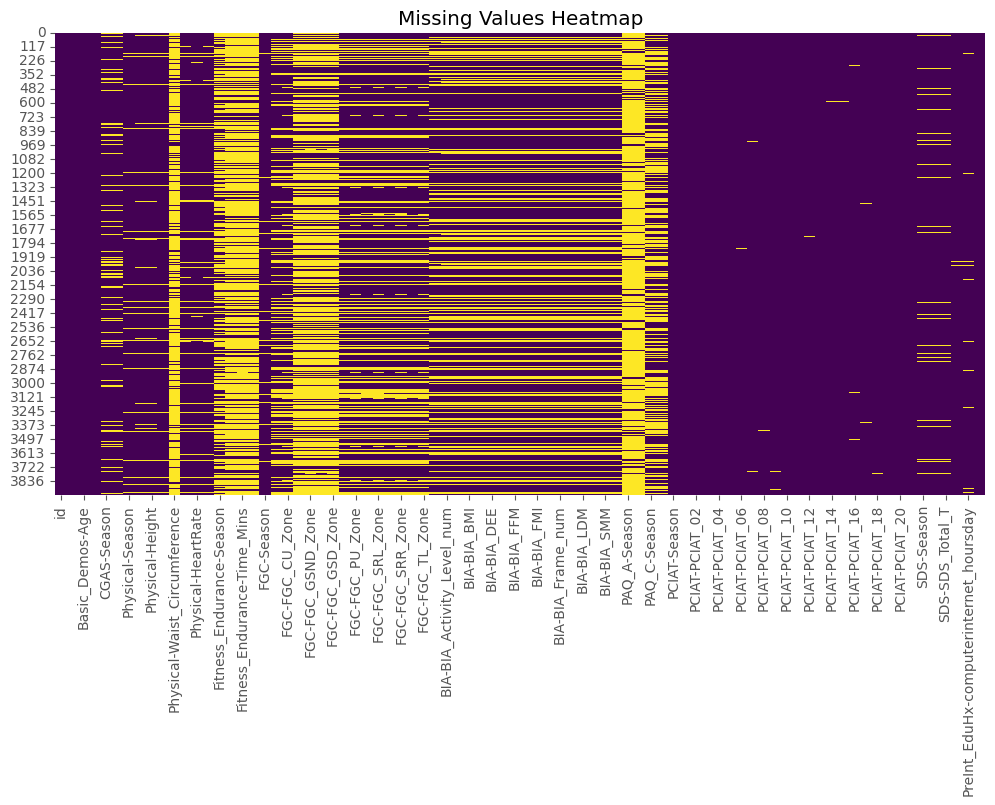

In [80]:
plt.figure(figsize=(12, 6))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

### 1.3.  Descriptive statistics

**Descriptive statistics (numerical data)**

In [81]:
train_data.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,2736.000000,2736.000000,2342.000000,2527.000000,2530.000000,2572.000000,483.000000,2478.000000,2486.000000,2478.000000,...,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2527.000000,2525.000000,2654.000000,2736.000000
mean,10.238670,0.364401,65.159266,19.125667,55.897051,87.839592,26.625259,69.755044,81.823411,117.127926,...,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,40.977839,57.647525,1.015072,0.580409
std,3.427982,0.481350,11.811050,4.909305,7.394938,43.353079,5.230213,13.790203,13.769816,17.221707,...,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.231384,13.042815,1.080861,0.771122
min,5.000000,0.000000,25.000000,0.000000,36.000000,0.000000,19.000000,11.000000,27.000000,49.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.773447,50.050000,57.200000,23.000000,61.000000,73.000000,107.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000,0.000000
50%,10.000000,0.000000,65.000000,17.819010,55.000000,75.800000,26.000000,68.000000,81.000000,114.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000,0.000000
75%,12.000000,1.000000,75.000000,21.172311,61.750000,111.450000,29.000000,76.000000,91.000000,125.000000,...,2.000000,3.000000,2.000000,2.000000,1.000000,41.000000,46.000000,64.000000,2.000000,1.000000
max,22.000000,1.000000,95.000000,46.102914,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,93.000000,96.000000,100.000000,3.000000,3.000000


**Descriptive statistics (Categorical Data)**

In [82]:
train_data.describe(include=['object', 'category'])

,id,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,SDS-Season,PreInt_EduHx-Season
count,2736,2736,2342,2595,1260,2647,1844,363,1440,2736,2527,2719
unique,2736,4,4,4,4,4,4,4,4,4,4,4
top,00008ff9,Spring,Spring,Spring,Spring,Spring,Summer,Winter,Spring,Spring,Spring,Spring
freq,1,734,665,709,377,771,585,98,405,762,692,728


### 1.4. Analyze the target variable

In [83]:
train_data['Severity_Level'] = train_data['PCIAT-PCIAT_Total'].apply(get_severity_level)
train_data['Severity_Level'].value_counts()

Severity_Level
None        1594
Mild         730
Moderate     378
Severe        34
Name: count, dtype: int64

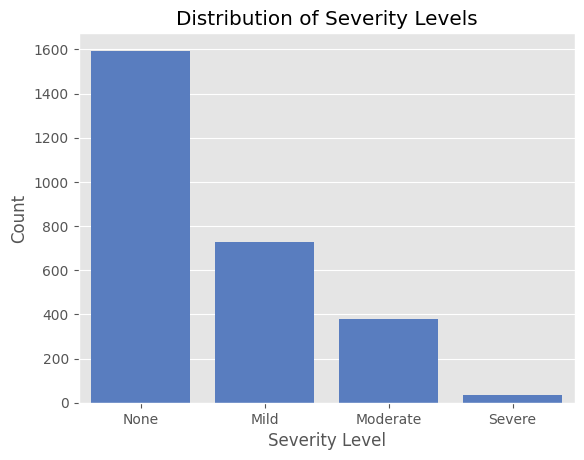

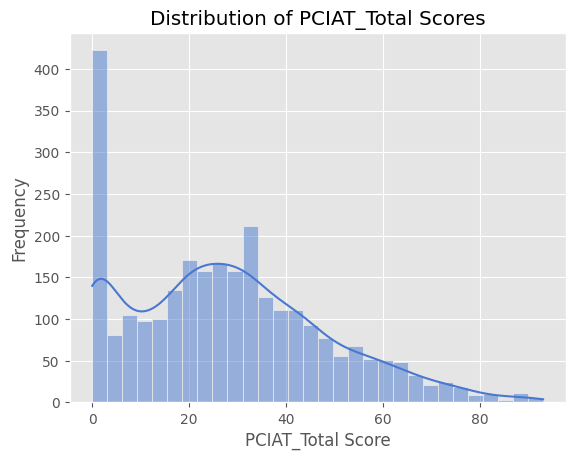

In [84]:
# Bar plot of Severity Levels
sns.countplot(x='Severity_Level', data=train_data, order=['None', 'Mild', 'Moderate', 'Severe'])
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.show()

# Histogram of PCIAT_Total scores
sns.histplot(train_data['PCIAT-PCIAT_Total'], bins=30, kde=True)
plt.title('Distribution of PCIAT_Total Scores')
plt.xlabel('PCIAT_Total Score')
plt.ylabel('Frequency')
plt.show()

In [85]:
# Check for class imbalance
severity_counts = train_data['Severity_Level'].value_counts()
severity_counts / len(train_data)

Severity_Level
None        0.582602
Mild        0.266813
Moderate    0.138158
Severe      0.012427
Name: count, dtype: float64

### 1.5. Correlation analysis

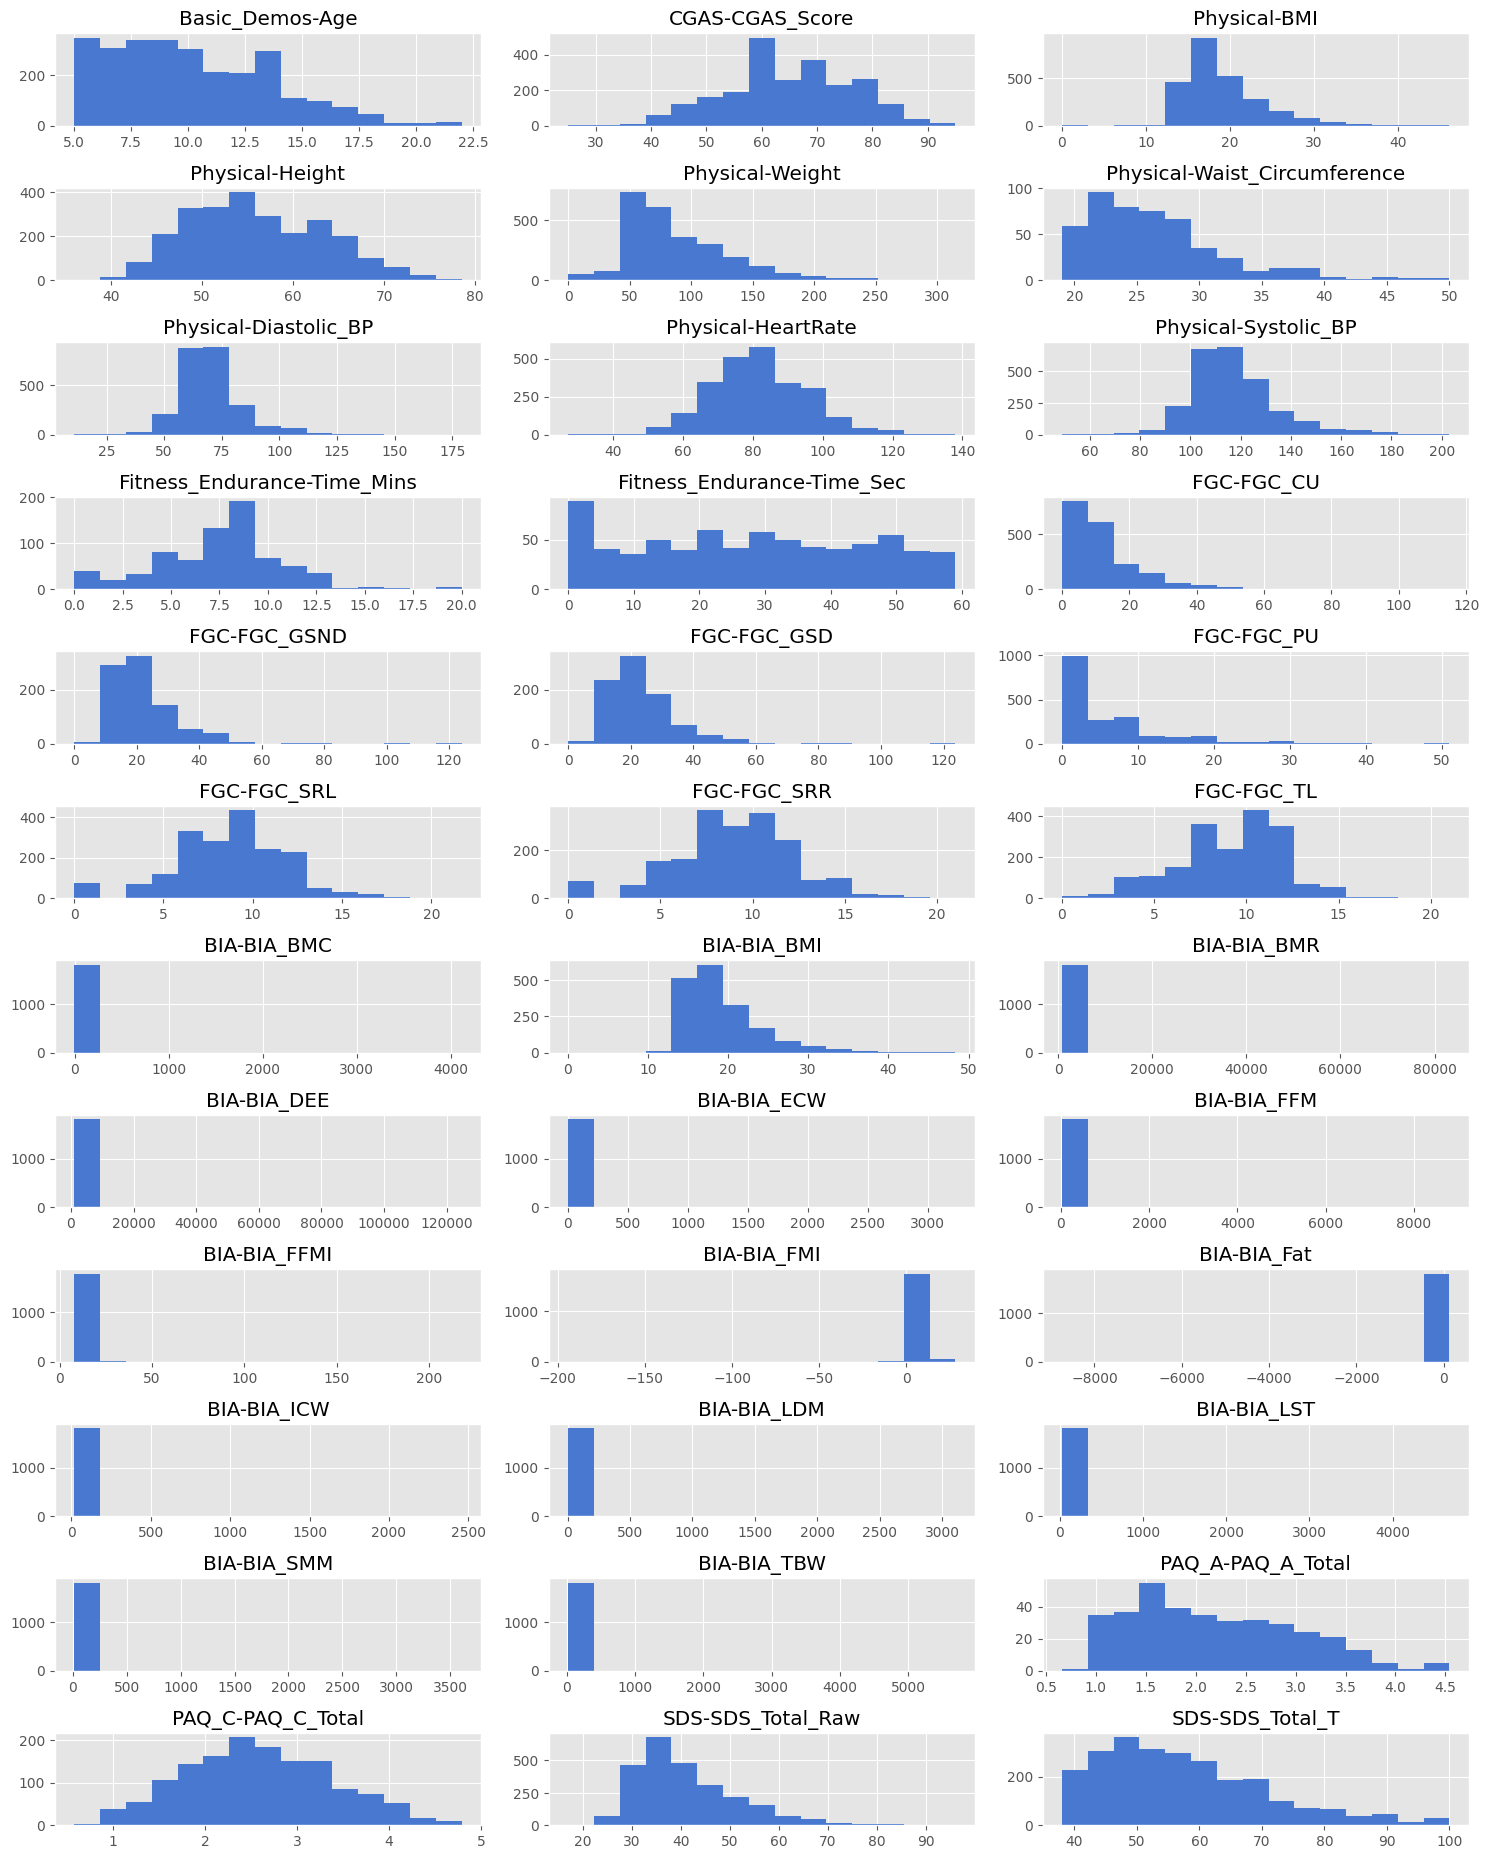

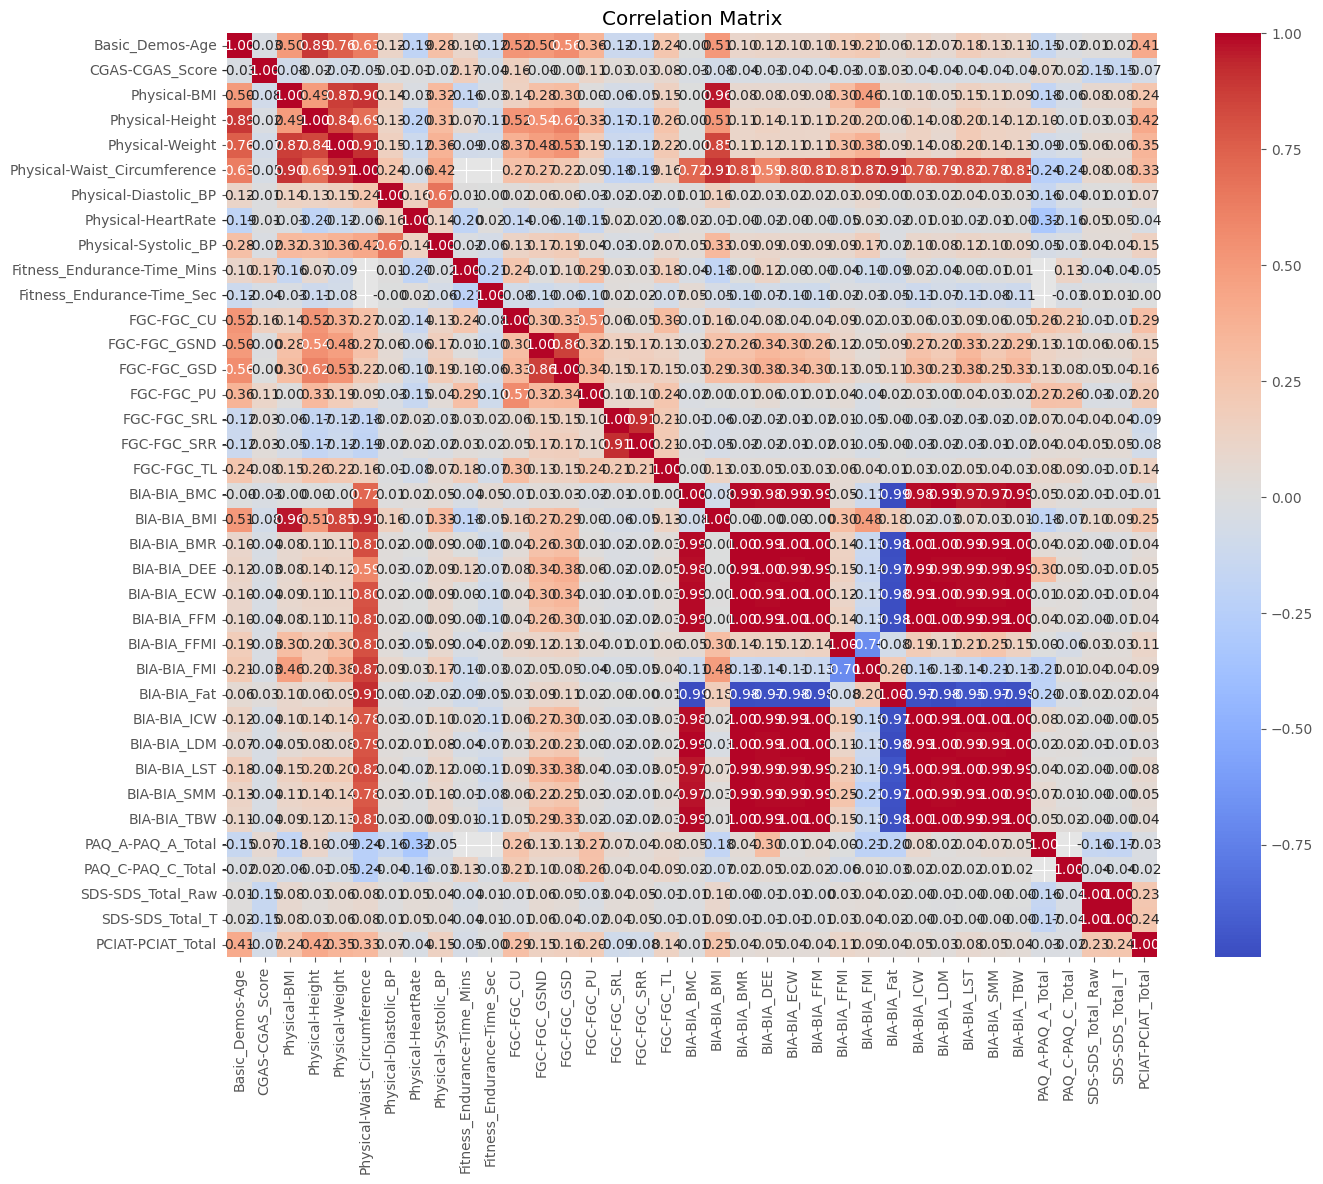

In [86]:

numerical_features = [
  "Basic_Demos-Age",
  "CGAS-CGAS_Score",
  "Physical-BMI",
  "Physical-Height",
  "Physical-Weight",
  "Physical-Waist_Circumference",
  "Physical-Diastolic_BP",
  "Physical-HeartRate",
  "Physical-Systolic_BP",
  "Fitness_Endurance-Time_Mins",
  "Fitness_Endurance-Time_Sec",
  "FGC-FGC_CU",
  "FGC-FGC_GSND",
  "FGC-FGC_GSD",
  "FGC-FGC_PU",
  "FGC-FGC_SRL",
  "FGC-FGC_SRR",
  "FGC-FGC_TL",
  "BIA-BIA_BMC",
  "BIA-BIA_BMI",
  "BIA-BIA_BMR",
  "BIA-BIA_DEE",
  "BIA-BIA_ECW",
  "BIA-BIA_FFM",
  "BIA-BIA_FFMI",
  "BIA-BIA_FMI",
  "BIA-BIA_Fat",
  "BIA-BIA_ICW",
  "BIA-BIA_LDM",
  "BIA-BIA_LST",
  "BIA-BIA_SMM",
  "BIA-BIA_TBW",
  "PAQ_A-PAQ_A_Total",
  "PAQ_C-PAQ_C_Total",
  # "PCIAT-PCIAT_Total",
  "SDS-SDS_Total_Raw",
  "SDS-SDS_Total_T",
]

# Visualize distributions using histograms
train_data[numerical_features].hist(bins=15, figsize=(15, 20), layout=(len(numerical_features) // 3 + 1, 3))
plt.tight_layout()
plt.show()

# Analyze correlations between numerical features and the target variable
corr_features = numerical_features + ['PCIAT-PCIAT_Total']
corr_data = train_data[corr_features]
correlation_matrix = corr_data.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [87]:
correlation_matrix['PCIAT-PCIAT_Total'].abs().sort_values(ascending=False)

PCIAT-PCIAT_Total               1.000000
Physical-Height                 0.420765
Basic_Demos-Age                 0.409559
Physical-Weight                 0.353048
Physical-Waist_Circumference    0.327013
FGC-FGC_CU                      0.287494
BIA-BIA_BMI                     0.248060
Physical-BMI                    0.240858
SDS-SDS_Total_T                 0.237718
SDS-SDS_Total_Raw               0.234432
FGC-FGC_PU                      0.196006
FGC-FGC_GSD                     0.160472
Physical-Systolic_BP            0.147081
FGC-FGC_GSND                    0.146813
FGC-FGC_TL                      0.136696
BIA-BIA_FFMI                    0.109694
FGC-FGC_SRL                     0.091221
BIA-BIA_FMI                     0.085863
FGC-FGC_SRR                     0.077836
BIA-BIA_LST                     0.075623
CGAS-CGAS_Score                 0.070542
Physical-Diastolic_BP           0.069321
BIA-BIA_DEE                     0.053094
BIA-BIA_SMM                     0.052912
BIA-BIA_ICW     

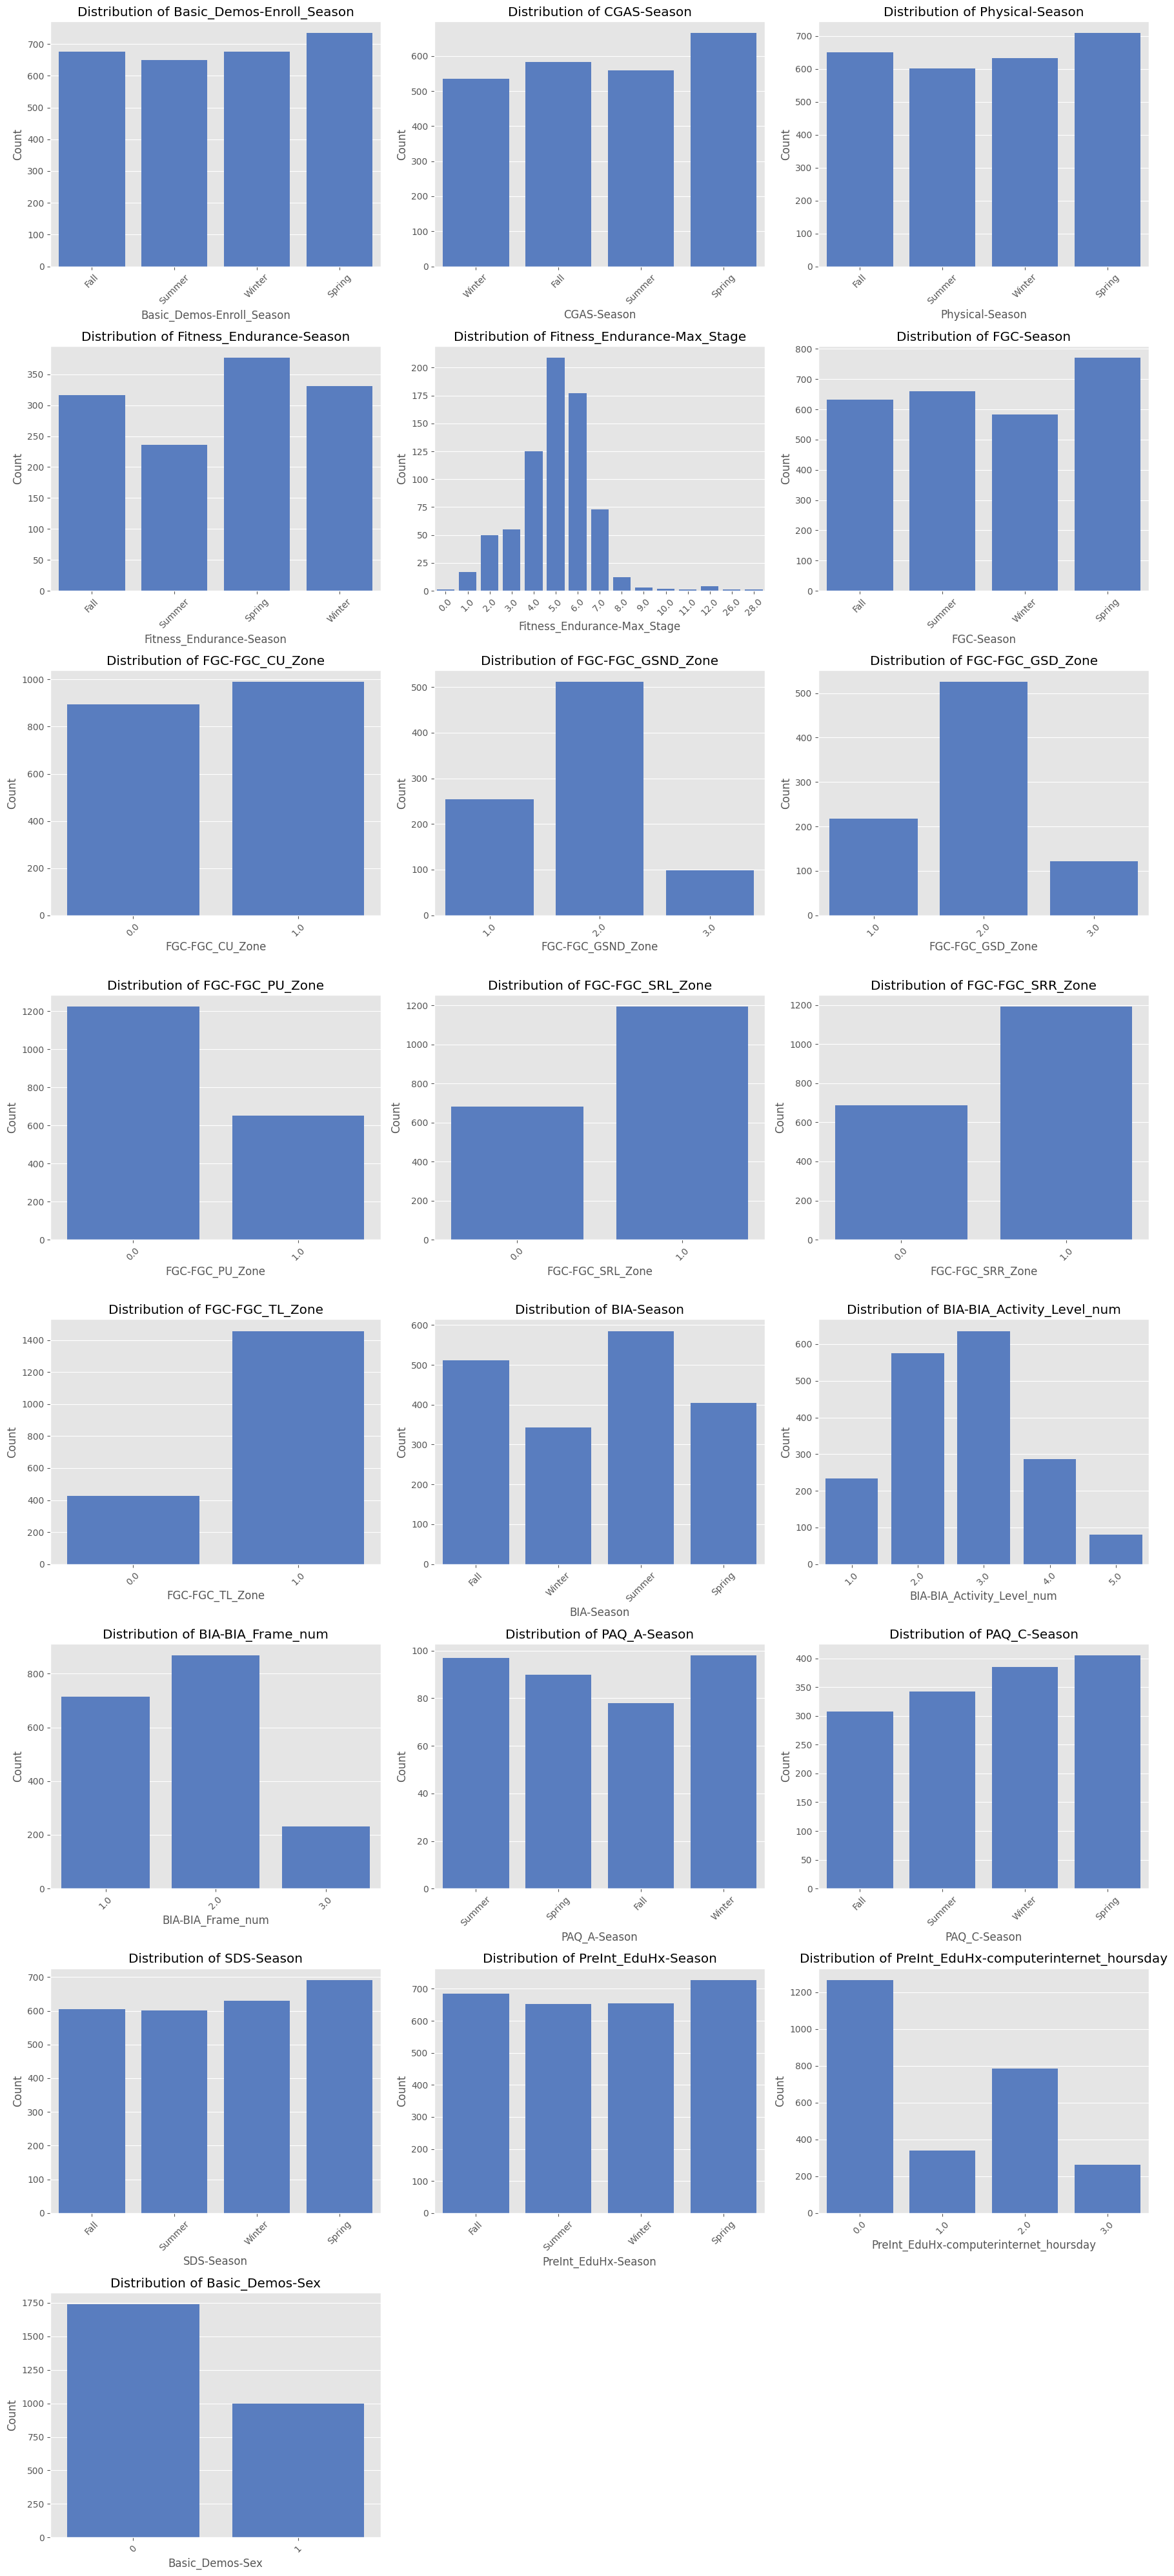

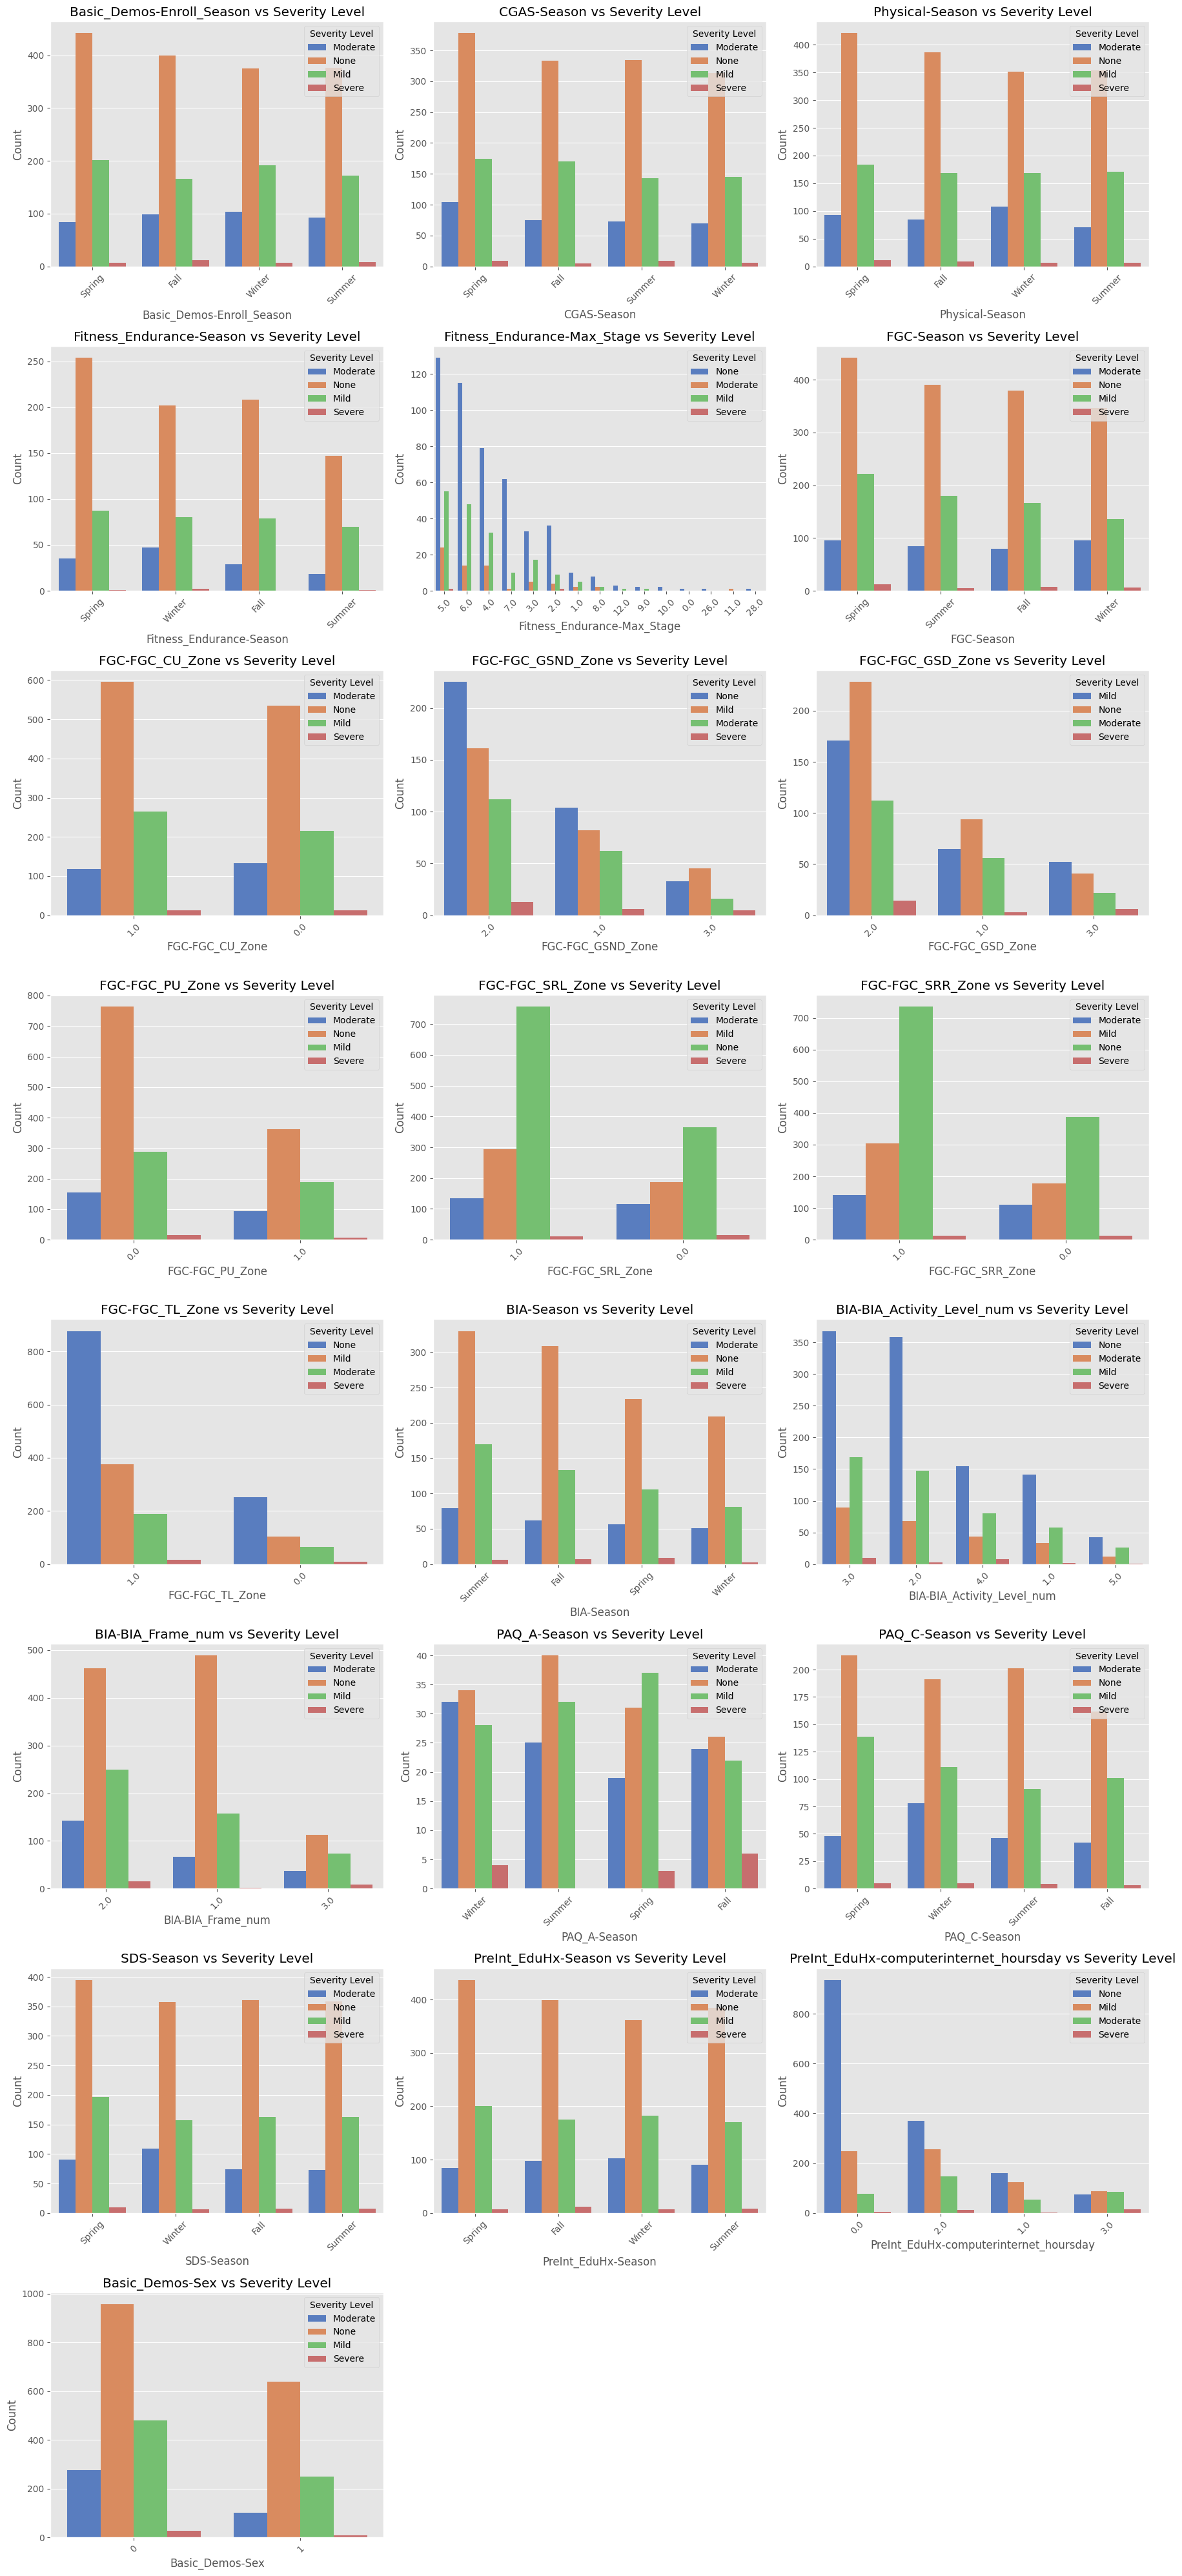

In [88]:
# Remove features that may not be in the dataset
categorical_features = [
    "Basic_Demos-Enroll_Season",
    "CGAS-Season",
    "Physical-Season",
    "Fitness_Endurance-Season",
    "Fitness_Endurance-Max_Stage",
    "FGC-Season",
    "FGC-FGC_CU_Zone",
    "FGC-FGC_GSND_Zone",
    "FGC-FGC_GSD_Zone",
    "FGC-FGC_PU_Zone",
    "FGC-FGC_SRL_Zone",
    "FGC-FGC_SRR_Zone",
    "FGC-FGC_TL_Zone",
    "BIA-Season",
    "BIA-BIA_Activity_Level_num",
    "BIA-BIA_Frame_num",
    "PAQ_A-Season",
    "PAQ_C-Season",
    "SDS-Season",
    "PreInt_EduHx-Season",
    "PreInt_EduHx-computerinternet_hoursday",
    "Basic_Demos-Sex"
]

categorical_features = [feature for feature in categorical_features if feature in train_data.columns]

# Analyze the distribution of categories for key features
fig, axes = plt.subplots(nrows=(len(categorical_features) + 2) // 3, ncols=3, figsize=(18, 5 * ((len(categorical_features) + 2) // 3)))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=train_data, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for idx in range(len(categorical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Visualize relationships between categorical features and the target variable
fig, axes = plt.subplots(nrows=(len(categorical_features) + 2) // 3, ncols=3, figsize=(18, 5 * ((len(categorical_features) + 2) // 3)))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='Severity_Level', data=train_data, order=train_data[feature].value_counts().index, ax=axes[idx])
    axes[idx].set_title(f'{feature} vs Severity Level')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Count')
    axes[idx].legend(title='Severity Level')
    axes[idx].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for idx in range(len(categorical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 2. Preprocessing

In [89]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

target_column = 'sii'
X = train_data[numerical_features + categorical_features]
y = train_data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the column transformer
preprocessor = ColumnTransformer(
    
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ]
)

# Fit the transformer on the training data
preprocessor.fit(X_train)

# Transform both train and test data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Output shapes
print(f"Transformed X_train shape: {X_train_transformed.shape}")
print(f"Transformed X_test shape: {X_test_transformed.shape}")

Transformed X_train shape: (2188, 140)
Transformed X_test shape: (548, 140)


In [90]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')),  # Handle NaN values
    ('dim_reduction', PCA()),
    ('classifier', RandomForestClassifier())  # Placeholder
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Basic_Demos-Age',
                                                   'CGAS-CGAS_Score',
                                                   'Physical-BMI',
                                                   'Physical-Height',
                                                   'Physical-Weight',
                                                   'Physical-Waist_Circumference',
                                                   'Physical-Diastolic_BP',
                                                   'Physical-HeartRate',
                                                   'Physical-Systolic_BP',
                                                   'Fitness_Endurance-Time_Mins',
                                                   'Fitness_Endurance-Time_Sec',
                                                   'FGC-FGC_CU', 'FG...
                                                   'FGC-FGC_PU_Zone',
                                                   'FGC-FGC_SRL_Zone',
                                                   'FGC-FGC_SRR_Zone',
                                                   'FGC-FGC_TL_Zone',
                                                   'BIA-Season',
                                                   'BIA-BIA_Activity_Level_num',
                                                   'BIA-BIA_Frame_num',
                                                   'PAQ_A-Season',
                                                   'PAQ_C-Season', 'SDS-Season',
                                                   'PreInt_EduHx-Season',
                                                   'PreInt_EduHx-computerinternet_hoursday',
                                                   'Basic_Demos-Sex'])])),
                ('imputer', SimpleImputer()), ('dim_reduction', PCA()),
                ('classifier', RandomForestClassifier())])

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB

# Models to use
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'Dummy': DummyClassifier(strategy='most_frequent', random_state=42)
}

# Example: Setting the pipeline's classifier to one of these models
pipeline.set_params(classifier=models['LogisticRegression'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Basic_Demos-Age',
                                                   'CGAS-CGAS_Score',
                                                   'Physical-BMI',
                                                   'Physical-Height',
                                                   'Physical-Weight',
                                                   'Physical-Waist_Circumference',
                                                   'Physical-Diastolic_BP',
                                                   'Physical-HeartRate',
                                                   'Physical-Systolic_BP',
                                                   'Fitness_Endurance-Time_Mins',
                                                   'Fitness_Endurance-Time_Sec',
                                                   'FGC-FGC_CU', 'FG...
                                                   'FGC-FGC_SRL_Zone',
                                                   'FGC-FGC_SRR_Zone',
                                                   'FGC-FGC_TL_Zone',
                                                   'BIA-Season',
                                                   'BIA-BIA_Activity_Level_num',
                                                   'BIA-BIA_Frame_num',
                                                   'PAQ_A-Season',
                                                   'PAQ_C-Season', 'SDS-Season',
                                                   'PreInt_EduHx-Season',
                                                   'PreInt_EduHx-computerinternet_hoursday',
                                                   'Basic_Demos-Sex'])])),
                ('imputer', SimpleImputer()), ('dim_reduction', PCA()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grids
param_grids = [
    {
        'dim_reduction__n_components': [5, 10, 20, 50],
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'dim_reduction__n_components': [5, 10, 20, 50],
        'classifier': [LogisticRegression(max_iter=1000, random_state=42)],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'dim_reduction__n_components': [5, 10, 20, 50],
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'dim_reduction__n_components': [5, 10, 20, 50],
        'classifier': [GaussianNB()]

    }
]

# Use GridSearchCV with combined parameter grids
grid_search = GridSearchCV(pipeline, param_grids, cv=5, scoring='accuracy', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

dummy_clf = DummyClassifier(strategy='most_frequent')


Fitting 5 folds for each of 76 candidates, totalling 380 fits
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, dim_reduction__n_components=5; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, dim_reduction__n_components=5; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, dim_reduction__n_components=5; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, dim_reduction__n_components=5; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, dim_reduction__n_components=5; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, dim_reduction__n_components=10; total time=   0.0s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, dim_reduction__n_components=10; total time=   0.1s
[CV] END classifier=SVC(), classifier__C=0.1, classifier__kernel=linear, di

In [103]:
# Output best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_
print(best_model)


Best Parameters:  {'classifier': LogisticRegression(max_iter=1000, random_state=42), 'classifier__C': 0.1, 'dim_reduction__n_components': 20}
Best Score:  0.595978182502116
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Basic_Demos-Age',
                                                   'CGAS-CGAS_Score',
                                                   'Physical-BMI',
                                                   'Physical-Height',
                                                   'Physical-Weight',
                                                   'Physical-Waist_Circumference',
                                                   'Physical-Diastolic_BP',
                                                   'Physical-HeartRate',
                                                   'Physical-Systolic_BP',
                                                   'Fitness_Endur

### 3. Re-train best models and Deploy the Final Model

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
target_names = ['None', 'Mild', 'Moderate', 'Severe']

from sklearn.utils.class_weight import compute_class_weight

# Balancing the classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
best_model.named_steps['classifier'].set_params(class_weight=dict(enumerate(class_weights)))

# Retrain the best model on the training dataset
best_model = grid_search.best_estimator_
best_model.fit(X, y)

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred, target_names= target_names))

# Evaluate the dummy classifier
dummy_clf.fit(X_train, y_train)
y_dummy_pred = dummy_clf.predict(X_test)
print("Classification Report for the Dummy Classifier:")
print(classification_report(y_test, y_dummy_pred, target_names= target_names))



Classification Report for the Best Model:
              precision    recall  f1-score   support

        None       0.76      0.68      0.72       336
        Mild       0.27      0.18      0.22       131
    Moderate       0.32      0.39      0.35        72
      Severe       0.12      0.89      0.21         9

    accuracy                           0.53       548
   macro avg       0.37      0.54      0.37       548
weighted avg       0.57      0.53      0.54       548

Classification Report for the Dummy Classifier:
              precision    recall  f1-score   support

        None       0.61      1.00      0.76       336
        Mild       0.00      0.00      0.00       131
    Moderate       0.00      0.00      0.00        72
      Severe       0.00      0.00      0.00         9

    accuracy                           0.61       548
   macro avg       0.15      0.25      0.19       548
weighted avg       0.38      0.61      0.47       548



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4. Evaluation of Results: Addressing Class Imbalance and Model Performance


In [116]:

from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(y_test, y_pred)
balanced_acc_dummy = balanced_accuracy_score(y_test, y_dummy_pred)

print("Normal accuracy Best Model",accuracy_score(y_test, y_pred))
print("Normal accuracy Dummy", accuracy_score(y_test, y_dummy_pred))
print("Balanced Accuracy Best Model:", balanced_acc)
print("Balanced Accuracy Dummy:", balanced_acc_dummy)


Normal accuracy Best Model 0.5291970802919708
Normal accuracy Dummy 0.6131386861313869
Balanced Accuracy Best Model: 0.5363769235429541
Balanced Accuracy Dummy: 0.25


#### Overview
The dataset used in this analysis exhibits significant class imbalance. The majority class (None) accounts for ~58% of the data, while the Severe class represents only ~1%. This imbalance poses a challenge for the classifier, as models tend to favor predicting the majority class, leading to misleadingly high accuracy but poor performance on minority classes.

##### Metrics Analysis


- Normal Accuracy:

    - Best Model: 52.92% 


    - Dummy Classifier: 61.31%


The dummy classifier achieves higher accuracy by always predicting the majority class (None). However, this is not a meaningful success as it completely ignores minority classes.


The best model, while less accurate overall, attempts to balance predictions across classes, leading to lower accuracy but better generalization to minority classes.
Balanced Accuracy:

- Best Model: 53.64%


- Dummy Classifier: 25.00%


Balanced accuracy measures the average recall across all classes, giving equal importance to each. The best model significantly outperforms the dummy classifier here, showing its ability to make predictions across all classes, even minority ones.


The dummy classifier’s poor balanced accuracy reflects its complete failure to predict any minority classes (Mild, Moderate, Severe).